# **Rossmann Project**

## **Data**

- data/train.csv - historical data including Sales
- data/test.csv - historical data excluding Sales
- data/store.csv - supplemental information about the stores

## **Import libs**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import math
import pickle

## **Overview**

### **Read data**

In [87]:
df_train = pd.read_csv("data/train.csv", low_memory=False)
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [88]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [89]:
df_store = pd.read_csv("data/store.csv")
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### **Merge data**

In [90]:
df = pd.merge(df_train, df_store, on='Store')

In [91]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


### **Shape**

In [17]:
df.shape

(1017209, 18)

## **EDA**

### **Missing values ?**

In [21]:
df.isna().sum().sort_values(ascending=False)

PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
DayOfWeek                         0
Promo2                            0
Assortment                        0
Store                             0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Sales                             0
Date                              0
StoreType                         0
dtype: int64

### **Unique values ?** 

In [28]:
cols = list(df.columns)
cols.remove("Date")
cols.remove("CompetitionDistance")
for col in cols:
    print(col, "---"*15, "\n", df[col].unique(),"\n")

Store --------------------------------------------- 
 [   1    2    3 ... 1113 1114 1115] 

DayOfWeek --------------------------------------------- 
 [5 4 3 2 1 7 6] 

Sales --------------------------------------------- 
 [ 5263  5020  4782 ... 20362 18841 21237] 

Customers --------------------------------------------- 
 [ 555  546  523 ... 3727 4022 4106] 

Open --------------------------------------------- 
 [1 0] 

Promo --------------------------------------------- 
 [1 0] 

StateHoliday --------------------------------------------- 
 ['0' 'a' 'b' 'c'] 

SchoolHoliday --------------------------------------------- 
 [1 0] 

StoreType --------------------------------------------- 
 ['c' 'a' 'd' 'b'] 

Assortment --------------------------------------------- 
 ['a' 'c' 'b'] 

CompetitionOpenSinceMonth --------------------------------------------- 
 [ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.] 

CompetitionOpenSinceYear --------------------------------------------- 
 [2008. 2

### **Sales by Year**

In [46]:
# getting year & month from Date
df['Year'] = df["Date"].apply(lambda x: int(x.split('-')[0]))
df['month'] = df["Date"].apply(lambda x: int(x.split('-')[1]))

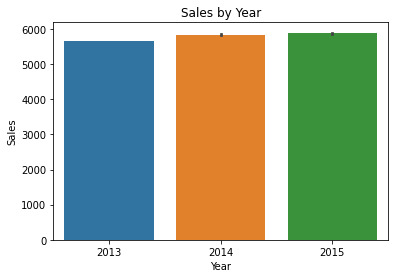

In [51]:
sns.barplot(x='Year', y='Sales', data=df).set(title="Sales by Year")
plt.show()

# Increasing Year to Year

### **Sales by week**

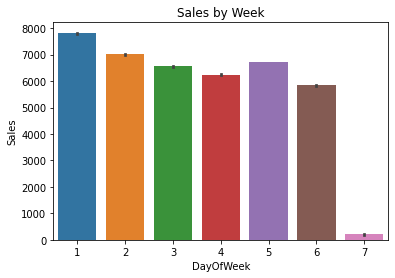

In [52]:
sns.barplot(x='DayOfWeek', y='Sales', data=df).set(title="Sales by Week")
plt.show()

# Monday and Friday are highest

### **Impact of Promo**

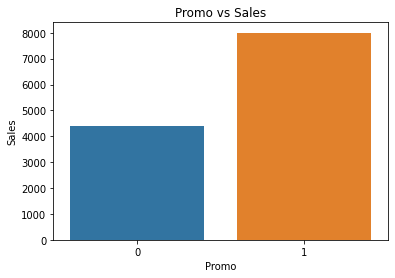

In [53]:
sns.barplot(x='Promo', y='Sales', data=df).set(title='Promo vs Sales')
plt.show()

# if Promo == True : Sales are higner

### **Impact of State Holiday**

StateHoliday - indicates a state holiday.  
Normally all stores, with few exceptions, are closed on state holidays.  
All schools are closed on public holidays and weekends.  
`a` = public holiday   
`b` = Easter holiday  
`c` = Christmas  
`0` = None  

In [54]:
df["StateHoliday"].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [63]:
df["StateHoliday"].dtypes

dtype('O')

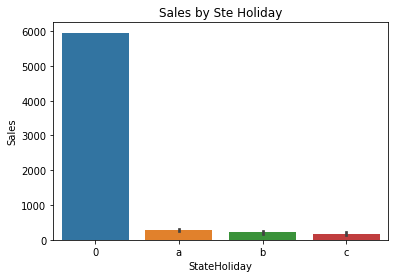

In [64]:
sns.barplot(x='StateHoliday', y='Sales', data=df).set(title='Sales by State Holiday')
plt.show()

# Less Sales on State Holiday

### **Impact of closure of public schools : School Holiday**

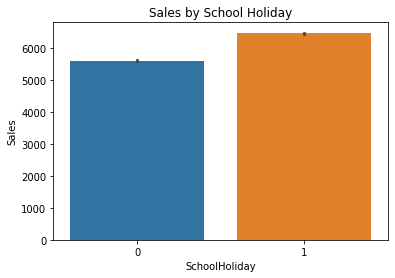

In [65]:
sns.barplot(x='SchoolHoliday', y='Sales', data=df).set(title='Sales by School Holiday')
plt.show()

# More Sales on School Holiday

### **Sales by StoreType**

In [66]:
# StoreType - differentiates between 4 different store models: a, b, c, d
df["StoreType"].value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

In [67]:
df["StoreType"].dtype

dtype('O')

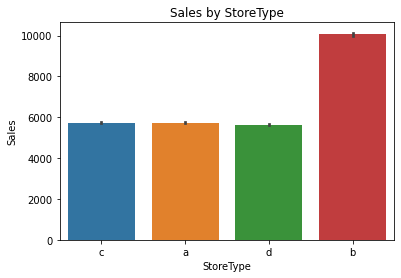

In [69]:
sns.barplot(x='StoreType', y='Sales', data=df).set(title='Sales by StoreType')
plt.show()

# Store b have the highest sales

### **Impact of Assortment**

In [70]:
# Assortment - describes an assortment level: a = basic, b = extra, c = extended
df["Assortment"].value_counts()

a    537445
c    471470
b      8294
Name: Assortment, dtype: int64

In [71]:
df["Assortment"].dtype

dtype('O')

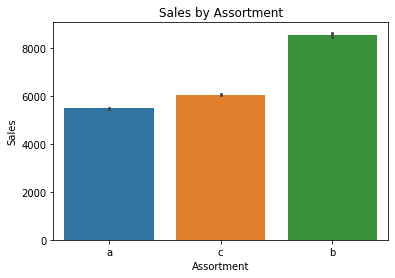

In [72]:
sns.barplot(x='Assortment', y='Sales', data=df).set(title='Sales by Assortment')
plt.show()

# Level b have the highest sales

## **Missing values**

In [92]:
df_clean = df.copy()

In [93]:
df_clean.isna().sum().sort_values(ascending=False)

PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
DayOfWeek                         0
Promo2                            0
Assortment                        0
Store                             0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Sales                             0
Date                              0
StoreType                         0
dtype: int64

### `PromoInterval` | `Promo2SinceYear` | `Promo2SinceWeek`

**_Method_**: 
- fill null values with `0` because `Promo2` is `0` for those stores

In [94]:
df_clean.update(df[['Promo2SinceWeek','Promo2SinceYear','PromoInterval']].fillna(0))

In [95]:
df_clean.isna().sum().sort_values(ascending=False)

CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
Store                             0
DayOfWeek                         0
Promo2SinceYear                   0
Promo2SinceWeek                   0
Promo2                            0
Assortment                        0
StoreType                         0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Sales                             0
Date                              0
PromoInterval                     0
dtype: int64

### `CompetitionOpenSinceYear` | `CompetitionOpenSinceMonth` | `CompetitionDistance`

**_Method_**:
- `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear` : most occuring month and year respectively
- `CompetitionDistance` :  mean of the distance given for all other stores

In [96]:
df_clean['CompetitionOpenSinceMonth'].fillna(df_clean['CompetitionOpenSinceMonth'].mode()[0],inplace=True)
df_clean['CompetitionOpenSinceYear'].fillna(df_clean['CompetitionOpenSinceYear'].mode()[0],inplace=True)

In [97]:
df_clean.isna().sum().sort_values(ascending=False)

CompetitionDistance          2642
Store                           0
DayOfWeek                       0
Promo2SinceYear                 0
Promo2SinceWeek                 0
Promo2                          0
CompetitionOpenSinceYear        0
CompetitionOpenSinceMonth       0
Assortment                      0
StoreType                       0
SchoolHoliday                   0
StateHoliday                    0
Promo                           0
Open                            0
Customers                       0
Sales                           0
Date                            0
PromoInterval                   0
dtype: int64

In [98]:
df_clean['CompetitionDistance'].fillna(df_clean['CompetitionDistance'].mean(), inplace=True)

In [100]:
# Check
df_clean.isna().sum().sum()

0

### **Impact of CompetitionDistance**

In [102]:
# CompetitionDistance - distance in meters to the nearest competitor store
df.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),title="Sales vs CompetitionDistance")
plt.show()

# more nearer more sales

<AxesSubplot:title={'center':'Sales vs CompetitionDistance'}, xlabel='CompetitionDistance', ylabel='Sales'>